# FIND FLOES AND CALCULATE FLOE STATISTICS

## Find floes and calculate floe basic floe statistics with ATL10 product
- Read ATL10 files
- Determine floe statistics (floe chord length, floe freeboard, lead width, etc.) using the ATL10 files in the Weddell Sea
- Create the result files in .pkl (pickled) and .nc (netCDF4) formats
- The pickled file contains floe information: floe length/freeboard for all detected floes, freeboard profiles for all detected floes, freeboard distribution, and lead distributions

Credited by Younghyun Koo (kooala317@gmail.com), Mukund Gupta, and Heather Regan

## (1) Import necessary libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, glob
import csv
import numpy as np
# import icepyx as ipx
from os import listdir
from os.path import isfile, join
import h5py
import matplotlib.pylab as plt
from math import *
import random
# import time
import pandas as pd
from tqdm import tqdm
import pickle

import cartopy.crs as ccrs
import datetime as dt
from shapely.geometry import Point
import geopandas
import scipy.stats as stats
import netCDF4
from netCDF4 import Dataset    # Note: python is case-sensitive!
from netCDF4 import date2num,num2date

from pyproj import Proj, transform
from shapely.geometry import Polygon
from sklearn.neighbors import KernelDensity


## (2) Define all necessary functions for floe analysis

In [2]:
# Functions 

def dist(lon1,lat1,lon2,lat2):

    lon1_rad = np.radians(lon1)
    lon2_rad = np.radians(lon2)
    lat1_rad = np.radians(lat1)
    lat2_rad = np.radians(lat2)
    #Assumes degrees input
    #Calculates in metres
    R = 6371000 #Radius of earth in metres (roughly)
    ## Uses Haversine formula
    a1 = (sin((lat2_rad-lat1_rad)/2))**2
    a2 = (cos(lat1_rad))*(cos(lat2_rad))*((sin((lon2_rad-lon1_rad)/2))**2)
    a = a1 + a2
    c = 2*atan2(sqrt(a),sqrt(1-a))
    d = R*c

    return d

# def get_chord_lengths(ice_leads_msk,fb_height,seg_dist_x):
#     floe_chord_lengths = np.zeros(len(ice_leads_msk)) # Making big enough array
#     floe_fb = np.zeros(len(ice_leads_msk)) # Making big enough array
#     ice_cnt_st = 0
#     ice_cnt_en = 0
#     floe_idx = 1
    
#     # ice_lead_msk: 0 (ice), 1 (lead)
#     for i in range(1,len(ice_leads_msk)):
#         if (ice_leads_msk[i] == 1) and (ice_leads_msk[i-1] == 0): # start floe
#             ice_cnt_st = i
#             ice_cnt_en  = i
#         elif (ice_leads_msk[i] == 1) and (ice_leads_msk[i-1] == 1): # grow floe
#             ice_cnt_en += 1
#         elif (ice_leads_msk[i-1] == 1) and (ice_leads_msk[i] == 0): # stop floe
#             floe_chord_lengths[floe_idx] = seg_dist_x[ice_cnt_en] - seg_dist_x[ice_cnt_st]
#             floe_fb[floe_idx] = np.mean(fb_height[ice_cnt_st:ice_cnt_en+1]) 
#             floe_idx += 1
            
#     # Removing spurious floes (< 10m, > 10 km, fb<0.1)
#     remove_idx = np.where(floe_chord_lengths < 10)[0]  
#     remove_idx = np.append(remove_idx,np.where(floe_chord_lengths > 10e3)[0])
#     remove_idx = np.append(remove_idx,np.where(floe_fb < 0.1)[0])
#     floe_fb = np.delete(floe_fb,remove_idx)
#     floe_chord_lengths = np.delete(floe_chord_lengths,remove_idx)
#     #
#     return floe_chord_lengths, floe_fb

# def get_chord_lengths(fb_height, seg_dist_x, stype, lead_values, seq = 2):
    
#     delta_seg_dist_x = np.append(0,np.diff(seg_dist_x)) 
#     spurious_msk = np.ones(np.shape(seg_dist_x))
#     spurious_msk[delta_seg_dist_x > 500] = 0
#     # Removing NaN values
#     spurious_msk[np.isnan(fb_height)] = 0

#     # Creating binary array for: leads or spurious (1) / ice (0)
#     ice_leads_msk = ice_leads_msk*spurious_msk
#     # 1 = lead, 0 = ice
    
#     floe_chord_lengths = np.zeros(len(ice_leads_msk)) # Making big enough array
#     floe_fb = np.zeros(len(ice_leads_msk)) # Making big enough array
#     ice_cnt_st = 0
#     ice_cnt_en = 0
#     floe_idx = 1
#     for i in range(1,len(ice_leads_msk)):
#         if (ice_leads_msk[i] == 0) and (np.prod(ice_leads_msk[max(0,i-seq):i]) == 1): # start floe
#             ice_cnt_st = i
#             ice_cnt_en = i
#         elif (ice_leads_msk[i] == 0) and (ice_leads_msk[i-1] == 0): # grow floe
#             ice_cnt_en += 1
#         elif (ice_leads_msk[i-1] == 0) and (np.prod(ice_leads_msk[i:min(i+seq,len(ice_leads_msk))]) == 1): # stop floe
#             floe_chord_lengths[floe_idx] = seg_dist_x[ice_cnt_en] - seg_dist_x[ice_cnt_st]
#             floe_fb[floe_idx] = np.mean(fb_height[ice_cnt_st:ice_cnt_en+1]) 
#             floe_idx += 1
            
            
# Function to calculate sea ice floe length
def get_floe_length(freeboard, lead_mask, seg_dist, seg_len, lat, lon, nprof = 50):
    # INPUT:
    # freeboard: along-track freeboard measurement of ICESat-2 ATL10 track
    # lead_mask: along-track lead detection result (0: lead; 1: non-lead)
    # seg_dist: along-track distance of ICESat-2 ATL10 track (unit: meters)
    # nprof: number of points in normalized profiles
    
    delta_dist = np.append(0, np.diff(seg_dist))
    
    # Floe parameters
    floe_length = np.array([]) # Floe length (unit: m)    
    floe_fb_mean = np.array([]) # Floe freeboard (unit: m) 
    floe_fb_median = np.array([]) # Floe freeboard (unit: m) 
    floe_fb_std = np.array([]) # Floe freeboard (unit: m)
    floe_lat = np.array([]) # Floe latitude
    floe_lon = np.array([]) # Floe longitude
    
    # Lead parameters
    lead_length = np.array([]) # Lead length (unit: m)
    lead_position = np.array([]) # Lead position (unit: m along the track)
    lead_fb = np.array([]) # Lead freeboard (unit: m)
    
    # Floe profile parameter
    rprof = np.linspace(0,1,nprof)
    floe_profiles = []
    
    # Floe starting index
    ice_cnt_st = 0
    # Floe ending index
    ice_cnt_en = 0
    
    # Lead starting index
    lead_cnt_st = 0
    # Lead ending index
    lead_cnt_en = 0    
    
    for i in range(1, len(freeboard)):
        # Remove invalid floe boundary:
        # If two ATL10 points are separated farther than 4 x (their segment length),
        # these two points are considered invalid
        # (because we cannot confirm the real sea ice condition (lead occurence, etc.) between them)
        if delta_dist[i] > 4*(seg_len[i] + seg_len[i-1]):
            freeboard[i] = np.nan
            freeboard[i-1] = np.nan
        
        if (lead_mask[i] == 0) and (lead_mask[i-1] == 1): # start floe & stop lead
            # Initialize floe
            ice_cnt_st = i
            ice_cnt_en = i
            
            # Complete lead
            lead_length = np.append(lead_length, abs(seg_dist[lead_cnt_en] - seg_dist[lead_cnt_st]) + 0.5*seg_len[lead_cnt_st] + 0.5*seg_len[lead_cnt_en])
            # lead_length = np.append(lead_length, np.sum(seg_len[lead_cnt_st:lead_cnt_en+1]))
            lead_fb = np.append(lead_fb, np.mean(freeboard[lead_cnt_st:lead_cnt_en+1]))
            lead_position = np.append(lead_position, (seg_dist[lead_cnt_en] + seg_dist[lead_cnt_st])/2)
                                    
        elif (lead_mask[i] == 0) and (lead_mask[i-1] == 0): # grow floe
            ice_cnt_en += 1
            
        elif (lead_mask[i] == 1) and (lead_mask[i-1] == 1): # grow lead
            lead_cnt_en += 1
            
        elif (lead_mask[i] == 1) and (lead_mask[i-1] == 0): # stop floe & start lead
            # Complete floe
            floe_length = np.append(floe_length, abs(seg_dist[ice_cnt_en] - seg_dist[ice_cnt_st]) + 0.5*seg_len[ice_cnt_st] + 0.5*seg_len[ice_cnt_en])
            # floe_length = np.append(floe_length, np.sum(seg_len[ice_cnt_st:ice_cnt_en+1]))
            floe_fb_mean = np.append(floe_fb_mean, np.mean(freeboard[ice_cnt_st:ice_cnt_en+1]))
            floe_fb_median = np.append(floe_fb_median, np.median(freeboard[ice_cnt_st:ice_cnt_en+1]))
            floe_fb_std = np.append(floe_fb_std, np.std(freeboard[ice_cnt_st:ice_cnt_en+1]))
            floe_lat = np.append(floe_lat, np.mean(lat[ice_cnt_st:ice_cnt_en+1]))
            floe_lon = np.append(floe_lon, np.mean(lon[ice_cnt_st:ice_cnt_en+1]))
            
            prof = fb[ice_cnt_st:ice_cnt_en+1]
            xx_prof = np.linspace(0,1,ice_cnt_en-ice_cnt_st+1)
            prof2 = np.interp(rprof, xx_prof, prof)
            floe_profiles.append(np.interp(rprof, xx_prof, prof))
            # floe_idx += 1
            
            # Initialize lead
            lead_cnt_st = i
            lead_cnt_en = i
        
    # Removing spurious floes (< 50m, > 10 km, fb < 0.1)
    
    # print(floe_length.shape, len(floe_profiles))
    idx = np.where((floe_length >= 10) & (floe_length <= 10000) & (floe_fb_mean >= 0.1))[0]  
    floe_fb_mean = floe_fb_mean[idx] #np.delete(floe_fb_mean, remove_idx)
    floe_fb_median = floe_fb_median[idx] #np.delete(floe_fb_median, remove_idx)
    floe_fb_std = floe_fb_std[idx] #np.delete(floe_fb_std, remove_idx)
    floe_length = floe_length[idx] #np.delete(floe_length, remove_idx)
    floe_lat = floe_lat[idx]
    floe_lon = floe_lon[idx]
    if len(floe_profiles) > 0:
        floe_profiles = np.array(floe_profiles)[idx, :].transpose() #np.array(floe_profiles)[~remove_idx, :].transpose()
    else:
        floe_profiles = np.array(floe_profiles)
    # print(floe_length.shape, floe_profiles.shape)
    
    # Removing spurious leads
    idx = np.where((lead_length >= 10) | (lead_fb <= 0.1))[0]
    lead_length = lead_length[idx] #np.delete(lead_length, remove_idx)    
    lead_position = lead_position[idx] #np.delete(lead_position, remove_idx)

    return floe_length, floe_fb_mean, floe_fb_median, floe_fb_std, floe_lat, floe_lon, lead_length, lead_position, floe_profiles

def get_lead_width_spacing_correlation(lead_widths,lead_positions,lead_width_bin_ranges):
    binned_lead_spacings = np.zeros(len(lead_width_bin_ranges)-1)
    binned_lead_count = np.zeros(len(lead_width_bin_ranges)-1)
    for i in range(len(lead_width_bin_ranges)-1):
        idx = np.where( (lead_widths >= lead_width_bin_ranges[i]) * (lead_widths < lead_width_bin_ranges[i+1]) )[0]
        spacings = np.abs(np.diff(lead_positions[idx]))
        if np.any(spacings):
            binned_lead_spacings[i] = np.mean(spacings)
            binned_lead_count[i] = len(idx) - 1 
    return binned_lead_count, binned_lead_spacings

# Calculate modal freeboard based on freeboard distribution
def calculate_mode(data, N = 10):
    data = data[~np.isnan(data)]
    w = 0.02
    M = 4
    m = w    
    
    if len(data) > N: # minimum number of freeboard observations to create distribution
        # instantiate and fit the KDE model
        kde = KernelDensity(bandwidth=w*5, kernel='gaussian')
        kde.fit(data[:, None])
        x_d = np.arange(m, M, w)
        logprob = kde.score_samples(x_d[:, None])
        n_max = np.argmax(np.exp(logprob))
        mode = x_d[n_max]
    elif len(data) > 0: # if the number of observation is not enough, just take 0.2 quantile
        mode = np.quantile(data, 0.2)
    else:
        mode = np.nan

    return mode


def smooth_line(data, x, w = 2):
    # Smooth the surface with the defined window size
    output = np.zeros(len(data))
    for n in range(0, len(data)):
#         output[n] = np.mean(data[max(0, n-w):min(len(data), n+w+1)])
        output[n] = np.mean(data[(x <= x[n]+w)&(x >= x[n]-w)])
    return output

# Calculate ridge fraction etc.
def calculate_ridge(df):
    
    mode, ridge_fr, ridge_h = 0,0,0;
    std, mean, med = 0,0,0;
    diff = df['freeboard'].values - df['fb_mode'].values
    
    if len(df) > 0:
        
        mode = np.nanmean(df['fb_mode'].values)
        std = np.nanstd(df['freeboard'].values)
        mean = np.nanmean(df['freeboard'].values)
        med = np.nanmedian(df['freeboard'].values)
        ridge_h = np.nanmean(diff[df['ridge']==1])
        ridge_fr = len(diff[df['ridge']==1]) / len(diff) * 100
        
#         mode = calculate_mode(freeboard)
#         ridge_fr = len(freeboard[freeboard > mode+0.6])/len(freeboard)*100
#         ridge_h = np.nanmean(freeboard[freeboard > mode+0.6]) - mode
    
    return [mode, ridge_fr, ridge_h, mean, med, std]

def calculate_lead(lead):
    return len(lead[lead == 1])/len(lead)*100

## (3) Process the floe analysis for all ATL10 files in the Weddell Sea (for loop)

In [263]:
# All ATL10 files stored in a folder
files = glob.glob("D:\\Floes\\ATL10\\*.h5")

# Test for three regions of the Weddell Sea
for region in ["west", "south", "entire"]:
    
    # Test different lead types
    lead_types = ["SD", "S", "F001", "F002"]
    if region == "west":
        bbox = [-65, -73, -45, -62]
    elif region == "south":
        bbox = [-65, -77.6, -15, -73]
    elif region == "entire":
        bbox = [-65, -77.6, -15, -62]

    for lead_type in lead_types: # "SD", "S", "F001", "F002"
        
        with Dataset(f'D:\\Floes\\array\\Grid_fb_v6_{region}_{lead_type}.nc', mode='w') as ncfile:
            
            # INITIALIZE NC FILE ==================================================================
            # Make grid for Weddell Sea (projection: NSIDC sea ice polar stereographic South - EPSG 3412)
            wide = 2500000
            y0 = 500000
            x0 = -2800000
            xp = np.arange(x0, x0+wide, 25000)
            yp = np.arange(y0, y0+wide, 25000)

            xx, yy = np.meshgrid(xp, yp)
            lats, lons = transform(Proj("EPSG:3412"), Proj("EPSG:4326"), xx, yy) 

            x_len = len(xp)
            y_len = len(yp)
            
            # CREATE NC FILE VARIABLES ================================
            x_dim = ncfile.createDimension('x', x_len)     # latitude axis
            y_dim = ncfile.createDimension('y', y_len)    # longitude axis
            time_dim = ncfile.createDimension('time', None) # unlimited axis (can be appended to).
            for dim in ncfile.dimensions.items():
                print(dim)

            ## XY grid ================================================
            x = ncfile.createVariable('x', np.float32, ('x',))
            x.units = 'meters'
            x.long_name = 'Center_x_values'
            y = ncfile.createVariable('y', np.float32, ('y',))
            y.units = 'meters'
            y.long_name = 'Center_y_values'

            ## Time ================================================
            time = ncfile.createVariable('time', np.float64, ('time',))
            time.units = 'hours since 1800-01-01'
            time.long_name = 'time'

            ## latitude & longitude ================================================
            latitude = ncfile.createVariable('lat', np.float64,('y','x',)) # note: unlimited dimension is leftmost
            latitude.units = 'degrees_north' # degrees Kelvin
            latitude.long_name = "latitude"

            longitude = ncfile.createVariable('lon', np.float64,('y','x',)) # note: unlimited dimension is leftmost
            longitude.units = 'degrees_east' # degrees Kelvin
            longitude.long_name = "longitude"

            ## Data variables ================================================
            fb_mode = ncfile.createVariable('fb_mode', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
            fb_mode.units = 'meters' # degrees meter
            fb_mode.standard_name = 'modal_freeboard' # this is a CF standard name
            
            fb_mean = ncfile.createVariable('fb_mean', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
            fb_mean.units = 'meters' # degrees meter
            fb_mean.standard_name = 'mean_freeboard' # this is a CF standard name
            
            fb_med = ncfile.createVariable('fb_med', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
            fb_med.units = 'meters' # degrees meter
            fb_med.standard_name = 'median_freeboard' # this is a CF standard name
            
            fb_std = ncfile.createVariable('fb_std', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
            fb_std.units = 'meters' # degrees meter
            fb_std.standard_name = 'standard_deviation_freeboard' # this is a CF standard name

            fr_ridge = ncfile.createVariable('fr_ridge', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
            # fr_ridge.units = 'meters' # no units
            fr_ridge.standard_name = 'ridge_fraction' # this is a CF standard name

            h_ridge = ncfile.createVariable('h_ridge', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
            h_ridge.units = 'meters' # degrees meter
            h_ridge.standard_name = 'mean_ridge_height' # this is a CF standard name

            fr_lead = ncfile.createVariable('fr_lead', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
            # fr_lead.units = 'meters' # no units
            fr_lead.standard_name = 'lead_fraction' # this is a CF standard name
            
            floe_leng = ncfile.createVariable('floe_len', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
            floe_leng.units = 'meters'
            floe_leng.standard_name = 'mean length (width) of sea ice floes' # this is a CF standard name
            
            floe_cnt = ncfile.createVariable('floe_cnt', np.float64,('time','x','y')) # note: unlimited dimension is leftmost
            # floe_cnt.units = 'meters' # no units
            floe_cnt.standard_name = 'number of sea ice floes' # this is a CF standard name
            
            x[:] = xp
            y[:] = yp

            latitude[:] = lats
            longitude[:] = lons
            ## ============================================================================
            
            nc_idx = 0
            
            print(region, lead_type)

            # Initializing freeboard distribution bin ranges
            step = 0.1
            ITD_bin_ranges = np.arange(0, 4.0+step, step) #np.arange(0.1, 1.5, num=50)
            ITD_bins = 0.5*(ITD_bin_ranges[0:-1] + ITD_bin_ranges[1:])

            #### ITD parameters ####
            cnt_file = 0
            ITD_all = np.zeros((len(ITD_bins),len(files)))
            year_all = np.zeros(len(files))
            month_all = np.zeros(len(files))
            day_all = np.zeros(len(files))
            valid_idx = []

            #### Floe parameters ####
            floe_year = np.array([])
            floe_month = np.array([])
            floe_day = np.array([])
            floe_len = np.array([])
            floe_lat = np.array([])
            floe_lon = np.array([])
            floe_fb_mean = np.array([])
            floe_fb_med = np.array([])
            floe_fb_std = np.array([])
            lead_width = np.array([])
            lead_position = np.array([])
            nprof = 50

            #### Lead parameters ####
            lead_width_bin_ranges = np.arange(10, 3000, 10)
            lead_width_bin_means = 0.5*(lead_width_bin_ranges[0:-1] + lead_width_bin_ranges[1:])
            binned_lead_count_all = np.zeros((len(lead_width_bin_means), len(files)))
            binned_lead_spacings_all = np.zeros((len(lead_width_bin_means), len(files)))

            first = True
            
            ## LOOP FOR ALL ATL10 FILES =================================================
            for k in tqdm(range(0, len(files))):
                filename = files[k]
                date = os.path.basename(filename)[9:9+14]
                year = int(date[:4])
                month = int(date[4:6])
                day = int(date[6:8])
                valid_beam = 0

                year_all[k] = year
                month_all[k] = month
                day_all[k] = day

                first_beam = True
                first_floe = True
                
                # Initialize grid (for nc file) -----------------------------------------
                grid_fb_mode = np.zeros(np.shape(xx)) * np.nan
                grid_fb_std = np.zeros(np.shape(xx)) * np.nan
                grid_fr_ridge = np.zeros(np.shape(xx)) * np.nan
                grid_h_ridge = np.zeros(np.shape(xx)) * np.nan
                grid_fr_lead = np.zeros(np.shape(xx)) * np.nan
                grid_floe_leng = np.zeros(np.shape(xx)) * np.nan
                grid_floe_cnt = np.zeros(np.shape(xx)) * np.nan
            
                polygons = []
                w = 12500
                for xi in xp[:]:
                    for yi in yp[:]:
                        polygons.append(Polygon([(xi-w,yi-w), (xi+w, yi-w), (xi+w, yi+w), (xi-w, yi+w)]))

                grid = geopandas.GeoDataFrame({'geometry':polygons}, crs = "EPSG:3412")
                grid['id'] = grid.index
                # -----------------------------------------------------------------
                
                df2 = pd.DataFrame({'lat': [], 'lon': []})
                df_floe = pd.DataFrame({'lat': [], 'lon': [], 'floe_len': []})

                with h5py.File(filename,'r') as f:

                    # Check the orbit orientation
                    orient = f['orbit_info/sc_orient'][0]
                    strong_beams = []

                    if orient == 0:
                        for i in [1, 2, 3]:
                            if f"gt{i}l" in f.keys():
                                strong_beams.append(f"gt{i}l")
                    elif orient == 1:
                        for i in [1, 2, 3]:
                            if f"gt{i}r" in f.keys():
                                strong_beams.append(f"gt{i}r")

                    for beam in strong_beams:

                        lat = f[beam]['freeboard_segment/latitude'][:]
                        lon = f[beam]['freeboard_segment/longitude'][:]
                        fb = f[beam]['freeboard_segment/beam_fb_height'][:]

                        idx = (lat >= bbox[1]) & (lat <= bbox[3]) & (lon >= bbox[0]) & (lon <= bbox[2])

                        lat = lat[idx]
                        lon = lon[idx]
                        fb = fb[idx]

                        seg_x = f[beam]['freeboard_segment/seg_dist_x'][idx] # (m to km)
                        seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][idx]
                        fb[fb > 100] = np.nan
                        stype = f[beam]['freeboard_segment/heights/height_segment_type'][idx]
                        refsur_ndx = f[beam]['freeboard_segment/beam_refsurf_ndx'][idx]
                        
                        # Calculate modal freeboard
                        freeboard_mode = np.zeros(np.shape(fb))
                        ridge = np.zeros(np.shape(fb))
                        sample_ndx = np.zeros(np.shape(fb))
                        
                        for i in np.unique(refsur_ndx):
                            part = (refsur_ndx == i)
                            x_min = np.min(seg_x[part])
                            x_max = np.max(seg_x[part])
                            sample_ndx[part] = i*10 + (seg_x[part] - x_min)//(10000/3)

                        for i in np.unique(sample_ndx):                
                            subndx = (sample_ndx == i)
                            subdata = fb[subndx]
                            freeboard_mode[subndx] = calculate_mode(subdata)
                            
                        # Ridge or not? (threshold 0.6 m above level (mode) freeboard)
                        ridge[fb > freeboard_mode + 0.6] = 1

                        df = pd.DataFrame({'lat': lat, 'lon': lon, 'seg_x': seg_x, 'seg_len': seg_len,
                                           'freeboard': fb, 'fb_mode': freeboard_mode, 'ridge': ridge, 'stype': stype})
                        df['beam'] = beam

                        if len(df) > 0 and np.sum(np.isnan(fb)) != len(fb):
                            
                            first_beam = False

                            if k not in valid_idx:
                                valid_idx.append(k)

                            ITD, _ = np.histogram(fb, bins=ITD_bin_ranges)
                            ITD_all[:, k] += ITD
                            
                            # DETERMINE LEAD --------------------------------------------------
                            lead_mask = np.zeros(len(fb))
                            if lead_type == "S":  # Specular leads
                                lead_mask[(stype <= 5) & (stype>= 2) & (fb < 0.1)] = 1 
                            elif lead_type == "SD":  # Specular + dark leads
                                lead_mask[(stype <= 9) & (stype>= 2) & (fb < 0.1)] = 1 
                            elif lead_type == "F001":  # Freeboard heights (0.01 m)
                                lead_mask[fb < 0.01] = 1
                            elif lead_type == "F002":  # Freeboard heights (0.02 m)
                                lead_mask[fb < 0.02] = 1
                            # ------------------------------------------------------------------
                            
                            df['lead'] = lead_mask
                            
                            df = df.dropna().reset_index(drop = True)
                            
                            df2 = df2.append(df).reset_index(drop=True)
                            
                            # CALCULATE FLOE STATISTICS (floe length, floe freeboard, lead width, etc.)
                            floe_len0, fb_mean0, fb_med0, fb_std0, floe_lat0, floe_lon0, lead_width0, lead_pos0, floe_profiles0 = get_floe_length(fb, lead_mask, seg_x, seg_len, lat, lon, nprof)

                            if len(floe_len0) > 0:
                                first_floe = False
                                df_floe0 = pd.DataFrame({'lat': floe_lat0, 'lon': floe_lon0, 'floe_len': floe_len0, 'floe_fb': fb_mean0})
                                df_floe = df_floe.append(df_floe0).reset_index(drop=True)
                                
                                # Combine the temporary record to the entire record
                                floe_year = np.append(floe_year, np.ones(len(floe_len0))*year)
                                floe_month = np.append(floe_month, np.ones(len(floe_len0))*month)
                                floe_day = np.append(floe_day, np.ones(len(floe_len0))*day)
                                floe_len = np.append(floe_len, floe_len0)
                                floe_fb_mean = np.append(floe_fb_mean, fb_mean0)
                                floe_fb_med = np.append(floe_fb_med, fb_med0)
                                floe_fb_std = np.append(floe_fb_std, fb_std0)
                                floe_lat = np.append(floe_lat, floe_lat0)
                                floe_lon = np.append(floe_lon, floe_lon0)

                                if first:
                                    floe_profiles = floe_profiles0
                                    first = False
                                else:
                                    floe_profiles = np.append(floe_profiles, floe_profiles0, axis = 1)

                            if len(lead_width0) > 0:
                                binned_lead_count0, binned_lead_spacings0 = get_lead_width_spacing_correlation(lead_width0,lead_pos0, lead_width_bin_ranges)
                                binned_lead_count_all[:, k] += binned_lead_count0
                                binned_lead_spacings_all[:, k] += binned_lead_spacings0
                                valid_beam += 1

                if first_beam == False:
                    
                    # Combine the results to the NC file grid -------------------------------------
                    gdf = geopandas.GeoDataFrame(df2, crs="EPSG:4326",
                                                 geometry=geopandas.points_from_xy(df2.lon, df2.lat)).to_crs("EPSG:3412")

                    gdf_floe = geopandas.GeoDataFrame(df_floe, crs="EPSG:4326",
                                                      geometry=geopandas.points_from_xy(df_floe.lon, df_floe.lat)).to_crs("EPSG:3412")
                    gdf_floe = gdf_floe.sjoin(grid, how="left").dropna()

                    left_df = gdf.sjoin(grid, how="left").dropna()

                    ridge = left_df.groupby("id").apply(calculate_ridge)
                    array_fb_mode = [s[0] for s in ridge.values]
                    array_fr_ridge = [s[1] for s in ridge.values]
                    array_h_ridge = [s[2] for s in ridge.values]
                    array_fb_mean = [s[3] for s in ridge.values]
                    array_fb_med = [s[4] for s in ridge.values]
                    array_fb_std = [s[5] for s in ridge.values]
                    array_fr_lead = left_df.groupby("id")["lead"].apply(calculate_lead).values
                    
                    array_floe_len = gdf_floe.groupby("id")["floe_len"].mean()
                    array_floe_cnt = gdf_floe.groupby("id")["lat"].count()

                    grid.loc[ridge.index, "fb_mode"] = array_fb_mode
                    grid.loc[ridge.index, "fr_ridge"] = array_fr_ridge
                    grid.loc[ridge.index, "h_ridge"] = array_h_ridge
                    grid.loc[ridge.index, "fr_lead"] = array_fr_lead
                    grid.loc[ridge.index, "fb_mean"] = array_fb_mean
                    grid.loc[ridge.index, "fb_med"] = array_fb_med
                    grid.loc[ridge.index, "fb_std"] = array_fb_std
                    grid.loc[array_floe_cnt.index, "floe_len"] = array_floe_len.values
                    grid.loc[array_floe_cnt.index, "floe_cnt"] = array_floe_cnt.values

                    fb_mode[nc_idx ,:,:] = grid["fb_mode"].values.reshape(np.shape(xx)).transpose()
                    fb_mean[nc_idx ,:,:] = grid["fb_mean"].values.reshape(np.shape(xx)).transpose()
                    fb_med[nc_idx ,:,:] = grid["fb_med"].values.reshape(np.shape(xx)).transpose()
                    fb_std[nc_idx ,:,:] = grid["fb_std"].values.reshape(np.shape(xx)).transpose()
                    fr_ridge[nc_idx ,:,:] = grid["fr_ridge"].values.reshape(np.shape(xx)).transpose()
                    h_ridge[nc_idx ,:,:] = grid["h_ridge"].values.reshape(np.shape(xx)).transpose()
                    fr_lead[nc_idx ,:,:] = grid["fr_lead"].values.reshape(np.shape(xx)).transpose()
                    
                    floe_leng[nc_idx ,:,:] = grid["floe_len"].values.reshape(np.shape(xx)).transpose()
                    floe_cnt[nc_idx ,:,:] = grid["floe_cnt"].values.reshape(np.shape(xx)).transpose()
                    time[nc_idx] = date2num(dt.datetime.strptime(date, "%Y%m%d%H%M%S"), time.units)
                    
                    nc_idx += 1

                if valid_beam > 0:
                    binned_lead_spacings_all[:, k] = binned_lead_spacings_all[:, k] / valid_beam

        ## SAVE ALL FLOE INFORMATION FILES INTO PICKLED FORMAT
        with open(f"D:\\Floes\\array\\fb_distribution_{region}_all_v6_{lead_type}.pkl", 'wb') as file:
            pickle.dump([year_all[valid_idx], month_all[valid_idx], day_all[valid_idx], ITD_bins, ITD_all[:, valid_idx]], file)

        with open(f"D:\\Floes\\array\\floe_profiles_{region}_all_v6_{lead_type}.pkl", 'wb') as file:
            pickle.dump([floe_year, floe_month, floe_day, floe_profiles, floe_len, floe_fb_mean], file)

        with open(f"D:\\Floes\\array\\floe_chord_full_{region}_all_v6_{lead_type}.pkl", 'wb') as file:
            pickle.dump([floe_year, floe_month, floe_day, floe_lat, floe_lon, floe_len, floe_fb_mean, floe_fb_med, floe_fb_std], file)

        with open(f"D:\\Floes\\array\\Lead_{region}_all_v6_{lead_type}.pkl", 'wb') as file:
            pickle.dump([year_all[valid_idx], month_all[valid_idx], day_all[valid_idx],
                         binned_lead_count_all[:, valid_idx], binned_lead_spacings_all[:, valid_idx], lead_width_bin_means], file)



('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 100)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 100)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
west SD


100%|████████████████████████████████████████████████████████████████████████████| 5776/5776 [1:36:21<00:00,  1.00s/it]


('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 100)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 100)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
west S


100%|████████████████████████████████████████████████████████████████████████████| 5776/5776 [1:37:49<00:00,  1.02s/it]


('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 100)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 100)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
west F001


100%|████████████████████████████████████████████████████████████████████████████| 5776/5776 [1:42:17<00:00,  1.06s/it]


('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 100)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 100)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
west F002


100%|████████████████████████████████████████████████████████████████████████████| 5776/5776 [1:40:21<00:00,  1.04s/it]


('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 100)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 100)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
south SD


100%|████████████████████████████████████████████████████████████████████████████| 5776/5776 [1:47:54<00:00,  1.12s/it]


('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 100)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 100)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
south S


100%|████████████████████████████████████████████████████████████████████████████| 5776/5776 [1:47:57<00:00,  1.12s/it]


('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 100)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 100)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
south F001


100%|████████████████████████████████████████████████████████████████████████████| 5776/5776 [1:47:51<00:00,  1.12s/it]


('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 100)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 100)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
south F002


100%|████████████████████████████████████████████████████████████████████████████| 5776/5776 [1:49:13<00:00,  1.13s/it]


('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 100)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 100)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
entire SD


100%|████████████████████████████████████████████████████████████████████████████| 5776/5776 [4:13:06<00:00,  2.63s/it]


('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 100)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 100)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
entire S


100%|████████████████████████████████████████████████████████████████████████████| 5776/5776 [6:11:36<00:00,  3.86s/it]


('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 100)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 100)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
entire F001


100%|████████████████████████████████████████████████████████████████████████████| 5776/5776 [6:12:08<00:00,  3.87s/it]


('x', <class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 100)
('y', <class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 100)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0)
entire F002


100%|████████████████████████████████████████████████████████████████████████████| 5776/5776 [6:22:07<00:00,  3.97s/it]


## Test some results

In [17]:
# All ATL10 files stored in a folder
files = glob.glob("D:\\Floes\\ATL10\\*.h5")

# Test for three regions of the Weddell Sea
region = "entire"
    
# Test different lead types
lead_types = ["SD", "S", "F001", "F002"]
if region == "west":
    bbox = [-65, -73, -45, -62]
elif region == "south":
    bbox = [-65, -77.6, -15, -73]
elif region == "entire":
    bbox = [-65, -77.6, -15, -62]

filename = files[1]

with h5py.File(filename,'r') as f:

    # Check the orbit orientation
    orient = f['orbit_info/sc_orient'][0]
    strong_beams = []

    if orient == 0:
        for i in [1, 2, 3]:
            if f"gt{i}l" in f.keys():
                strong_beams.append(f"gt{i}l")
    elif orient == 1:
        for i in [1, 2, 3]:
            if f"gt{i}r" in f.keys():
                strong_beams.append(f"gt{i}r")

    for beam in strong_beams:

        lat = f[beam]['freeboard_segment/latitude'][:]
        lon = f[beam]['freeboard_segment/longitude'][:]
        fb = f[beam]['freeboard_segment/beam_fb_height'][:]

        idx = (lat >= bbox[1]) & (lat <= bbox[3]) & (lon >= bbox[0]) & (lon <= bbox[2])

        lat = lat[idx]
        lon = lon[idx]
        fb = fb[idx]

        seg_x = f[beam]['freeboard_segment/seg_dist_x'][idx] # (m to km)
        seg_len = f[beam]['freeboard_segment/heights/height_segment_length_seg'][idx]
        fb[fb > 100] = np.nan
        stype = f[beam]['freeboard_segment/heights/height_segment_type'][idx]
        refsur_ndx = f[beam]['freeboard_segment/beam_refsurf_ndx'][idx]

        # Calculate modal freeboard
        freeboard_mode = np.zeros(np.shape(fb))
        ridge = np.zeros(np.shape(fb))
        sample_ndx = np.zeros(np.shape(fb))

        for i in np.unique(refsur_ndx):
            part = (refsur_ndx == i)
            x_min = np.min(seg_x[part])
            x_max = np.max(seg_x[part])
            sample_ndx[part] = i*10 + (seg_x[part] - x_min)//(10000/3)

        for i in np.unique(sample_ndx):                
            subndx = (sample_ndx == i)
            subdata = fb[subndx]
            freeboard_mode[subndx] = calculate_mode(subdata)
            
        lead_mask = {} #np.zeros(len(fb))
        for lead_type in ["S", "SD", "F001", "F002"]:
            lead_mask[lead_type] = np.zeros(len(fb))
            if lead_type == "S":  # Specular leads
                lead_mask[lead_type][(stype <= 5) & (stype>= 2) & (fb < 0.1)] = 1 
            elif lead_type == "SD":  # Specular + dark leads
                lead_mask[lead_type][(stype <= 9) & (stype>= 2) & (fb < 0.1)] = 1 
            elif lead_type == "F001":  # Freeboard heights (0.01 m)
                lead_mask[lead_type][fb < 0.01] = 1
            elif lead_type == "F002":  # Freeboard heights (0.02 m)
                lead_mask[lead_type][fb < 0.02] = 1

        # Ridge or not? (threshold 0.6 m above level (mode) freeboard)
        ridge[fb > freeboard_mode + 0.6] = 1

        df = pd.DataFrame({'lat': lat, 'lon': lon, 'seg_x': seg_x, 'seg_len': seg_len,
                           'freeboard': fb, 'fb_mode': freeboard_mode, 'ridge': ridge, 'stype': stype})
        df['beam'] = beam

(27550000.0, 27555000.0)

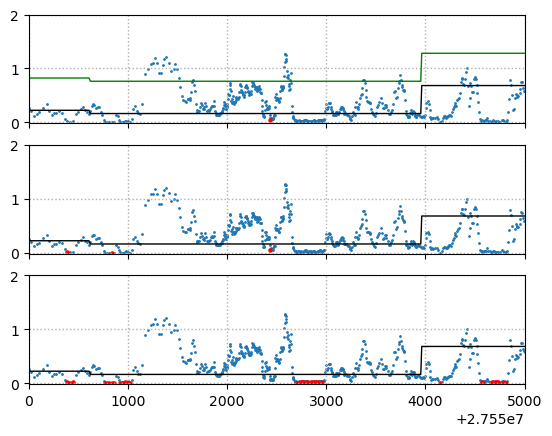

In [52]:
fig,ax = plt.subplots(3, 1, sharex = True)
ax[0].scatter(seg_x[lead_mask["S"]==0], fb[lead_mask["S"]==0], s=1)
ax[0].plot(seg_x, freeboard_mode, c="k", lw = 1)
ax[0].plot(seg_x, freeboard_mode+0.6, c="g", lw = 1)
ax[0].scatter(seg_x[lead_mask["S"]==1], fb[lead_mask["S"]==1], s=5, c = "r")

ax[0].set_ylim(-0.02, 2)
ax[0].grid(ls=":", lw=1)

ax[1].scatter(seg_x[lead_mask["SD"]==0], fb[lead_mask["SD"]==0], s=1)
ax[1].plot(seg_x, freeboard_mode, c="k", lw = 1)
ax[1].scatter(seg_x[lead_mask["SD"]==1], fb[lead_mask["SD"]==1], s=5, c = "r")
ax[1].set_ylim(-0.02, 2)
ax[1].grid(ls=":", lw=1)

ax[2].scatter(seg_x[lead_mask["F002"]==0], fb[lead_mask["F002"]==0], s=1)
ax[2].plot(seg_x, freeboard_mode, c="k", lw = 1)
ax[2].scatter(seg_x[lead_mask["F002"]==1], fb[lead_mask["F002"]==1], s=5, c = "r")
ax[2].set_ylim(-0.02, 2)
ax[2].grid(ls=":", lw=1)

ax[2].set_xlim(27585000, 27590000) # good example?
ax[2].set_xlim(27550000, 27555000) # so-so?

In [ ]:
plt.scatter(floe_lon, floe_lat, c=floe_month)

(100, 100) (100, 100) (100, 100) (100, 100)


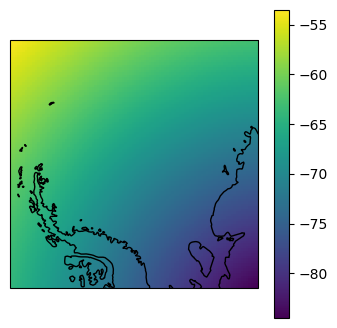

In [141]:
width = 2500000
y0 = 500000
x0 = -2800000
xp = np.arange(x0, x0+width, 25000)
yp = np.arange(y0, y0+width, 25000)

xx, yy = np.meshgrid(xp, yp)
lats, lons = transform(Proj("EPSG:3412"), Proj("EPSG:4326"), xx, yy)
print(xx.shape, yy.shape, lats.shape, lons.shape)

fig, ax = plt.subplots(1, 1, figsize=(4,4), dpi= 100, subplot_kw={'projection': ccrs.SouthPolarStereo()})
m = ax.pcolormesh(xx, yy, lats)
fig.colorbar(m, ax=ax)
ax.coastlines()
ax.grid()

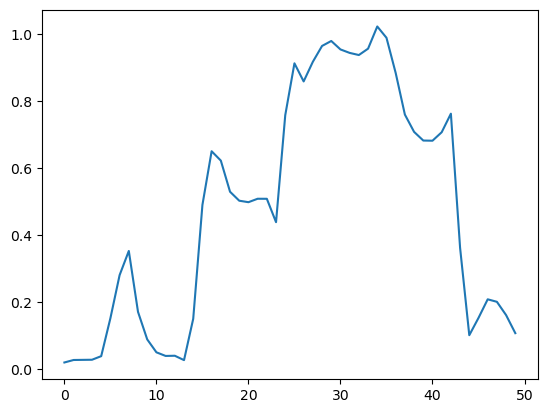

In [423]:
plt.plot(floe_profiles[:, 150])

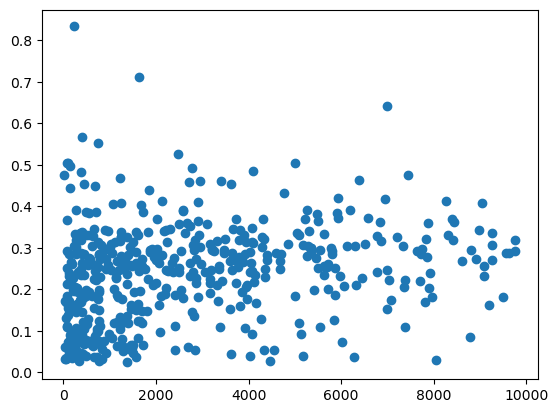

In [369]:
plt.scatter(floe_len, floe_fb_std)

(28000000.0, 28040000.0)

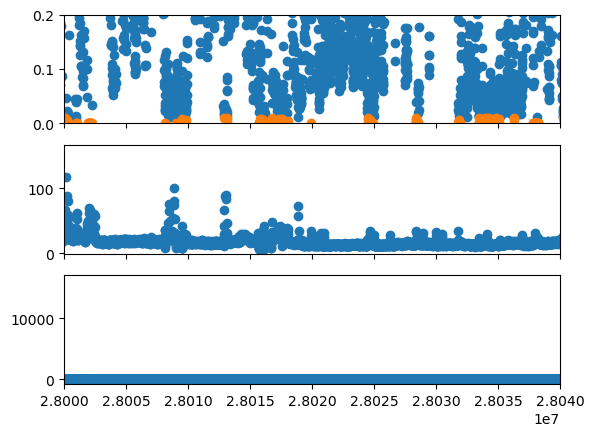

In [187]:
fig,ax = plt.subplots(3, 1, sharex = True)
ax[0].scatter(seg_dist[lead_mask==0], freeboard[lead_mask==0])
ax[0].scatter(seg_dist[lead_mask==1], freeboard[lead_mask==1])
ax[0].set_ylim(0, 0.2)
ax[1].scatter(seg_dist, seg_len)
ax[2].scatter(seg_dist, delta_dist)
# plt.scatter(lead_position, lead_length/lead_length)
# plt.ylim(0,100)
ax[2].set_xlim(28000000, 28040000)